In [2]:
from pandas import json_normalize
import pandas as pd
import json
import requests
import shutil
import os
import sys
from urllib.parse import urlparse
from SPARQLWrapper import SPARQLWrapper, JSON
from PIL import Image, ExifTags

# URL du point d'accès SPARQL
endpoint_url = "https://query.wikidata.org/sparql"

# Requête SPARQL
query = """SELECT DISTINCT ?grandeville ?grandevilleLabel ?pays ?paysLabel ?image {
  ?grandeville wdt:P31 wd:Q570116;
               wdt:P17 ?pays;
               wdt:P18 ?image.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
LIMIT 120"""

def get_results(endpoint_url, query):
    user_agent = f"WDQS-example Python/{sys.version_info[0]}.{sys.version_info[1]}"
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

# Récupération des résultats
array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    array.append(
        (
            result["grandevilleLabel"]["value"],
            result["paysLabel"]["value"],
            result["image"]["value"],
        )
    )
dataframe = pd.DataFrame(array, columns=["ville", "pays", "image"])
dataframe = dataframe.astype(dtype={"ville": "<U200", "pays": "<U200", "image": "<U200"})

# Création du dossier 'images' s'il n'existe pas
if not os.path.exists("images"):
    os.makedirs("images")

# Dossier pour stocker les métadonnées
metadata_file = "image_metadata.json"
metadata_list = []

from PIL import Image, ExifTags




def download_image(url, folder="images"):
    """Télécharge une image et enregistre ses métadonnées."""
    headers = {"User-Agent": "Mozilla/5.0"}
    parsed_url = urlparse(url)
    filename = os.path.basename(parsed_url.path)
    file_path = os.path.join(folder, filename)
    try:
        request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
        if request.status_code == 200:
            with open(file_path, "wb") as image:
                request.raw.decode_content = True
                shutil.copyfileobj(request.raw, image)
            print(f"[✔] Image téléchargée : {file_path}")
            metadata = get_image_metadata(file_path)
            if metadata:
                metadata_list.append(metadata)
        else:
            print(f"[✘] Erreur HTTP {request.status_code} pour {url}")
    except Exception as e:
        print(f"[✘] Erreur lors du téléchargement {url}: {e}")

# Téléchargement des images
dataframe.image.apply(lambda url: download_image(url, "images"))

# Sauvegarde des métadonnées
with open(metadata_file, "w", encoding="utf-8") as f:
    json.dump(metadata_list, f, ensure_ascii=False, indent=4)

print("✅ Téléchargement terminé et métadonnées enregistrées !")

[✘] Erreur lors de la lecture des métadonnées de images/exemple.jpg : [Errno 2] No such file or directory: 'images/exemple.jpg'
None
[✔] Image téléchargée : images/Niagara%20Falls%20Skyline.jpg
[✔] Image téléchargée : images/Castell%20Caernarfon%20yn%20y%20cyfnos%20yn%202023%20-%20Castell%20Caernarfon%2C%20Gwynedd%2C%20Wales%20at%20Dusk%20-%202023%2010.png
[✔] Image téléchargée : images/Circus%20max%201978.jpg
[✔] Image téléchargée : images/Piazza%20della%20signoria%2C%20palazzo%20vecchio%2C%20veduta%2001.jpg
[✔] Image téléchargée : images/Kazakhstan%20P9200599%2014%20%2839253139165%29.jpg
[✔] Image téléchargée : images/Jardin%20du%20Luxembourg.JPG
[✔] Image téléchargée : images/Jardin%20du%20Luxembourg%20in%20Fall%202019.jpg
[✔] Image téléchargée : images/Jardins%20du%20Luxembourg%204.JPG
[✔] Image téléchargée : images/LuxembourgMontparnasse%202.jpg
[✔] Image téléchargée : images/Meotoiwa.jpg
[✔] Image téléchargée : images/Courtyard%20of%20Meiji%20Shrine%2020190717.jpg
[✔] Image téléc

TypeError: Object of type IFDRational is not JSON serializable

In [1]:
import os
import json
from PIL import Image
from PIL.ExifTags import TAGS
from collections import Counter

### --- Chargement et gestion de la palette de couleurs XKCD --- ###
def load_xkcd_colors():
    """Charge la palette de couleurs nommées de XKCD."""
    xkcd_colors = {
        "cloudy blue": "#acc2d9", "dark pastel green": "#56ae57",
        "dust": "#b2996e", "electric lime": "#a8ff04",
        "fresh green": "#69d84f", "light eggplant": "#894585",
        "nasty green": "#70b23f", "really light blue": "#d4ffff",
        "tea": "#65ab7c", "warm purple": "#952e8f",
        "yellowish tan": "#fcfc81", "cement": "#a5a391",
        "dark grass green": "#388004", "dusty teal": "#4c9085",
        "grey teal": "#5e9b8a", "macaroni and cheese": "#efb435",
        "pinkish tan": "#d99b82", "spruce": "#0a5f38",
        "strong blue": "#0c06f7", "toxic green": "#61de2a",
        "windows blue": "#3778bf", "blue blue": "#2242c7",
        "blue with a hint of purple": "#533cc6", "booger": "#9bb53c",
        "bright sea green": "#05ffa6", "dark green blue": "#1f6357",
        "deep turquoise": "#017374", "green teal": "#0cb577",
        "strong pink": "#ff0789", "bland": "#afa88b",
        "deep aqua": "#08787f", "lavender pink": "#dd85d7",
        "light moss green": "#a6c875", "light seafoam green": "#a7ffb5",
        "olive yellow": "#c2b709", "pig pink": "#e78ea5",
        "deep lilac": "#966ebd", "desert": "#ccad60",
        "dusty lavender": "#ac86a8", "purpley grey": "#947e94",
        "purply": "#983fb2", "candy pink": "#ff63e9",
        "light pastel green": "#b2fba5", "boring green": "#63b365"
    }
    return xkcd_colors

def closest_xkcd_color(requested_color):
    """Retourne la couleur nommée la plus proche dans la palette XKCD."""
    xkcd_colors = load_xkcd_colors()
    
    min_distance = float("inf")
    closest_name = "unknown"

    for name, hex_code in xkcd_colors.items():
        r_c, g_c, b_c = [int(hex_code[i:i+2], 16) for i in (1, 3, 5)]
        distance = sum((requested_color[i] - [r_c, g_c, b_c][i]) ** 2 for i in range(3))

        if distance < min_distance:
            min_distance = distance
            closest_name = name
    
    return closest_name

### --- Fonction pour récupérer la couleur dominante --- ###
def get_dominant_color(image, num_colors=5):
    """Analyse l'image et retourne la couleur dominante sous forme hexadécimale."""
    image = image.convert("RGB")  # Convertir en RGB
    pixels = list(image.getdata())  
    most_common_colors = Counter(pixels).most_common(num_colors)  # Trouver les couleurs les plus fréquentes

    # Sélectionner la plus fréquente
    dominant_color = most_common_colors[0][0] if most_common_colors else (0, 0, 0)  
    return "#{:02x}{:02x}{:02x}".format(*dominant_color)  # Convertir en format hex

### --- Fonction pour extraire les métadonnées EXIF --- ###
def get_exif_data(image):
    """Récupère les métadonnées EXIF d'une image."""
    exif_data = {}
    try:
        exif_raw = image._getexif()
        if exif_raw:
            for tag, value in exif_raw.items():
                tag_name = TAGS.get(tag, tag)
                exif_data[tag_name] = value

        # Extraction des informations utiles
        device_make = exif_data.get("Make", "Inconnu")
        device_model = exif_data.get("Model", "Inconnu")
        creation_date = exif_data.get("DateTimeOriginal", exif_data.get("DateTime", "Inconnue"))

        return device_make, device_model, creation_date
    except Exception:
        return "Inconnu", "Inconnu", "Inconnue"

### --- Fonction principale pour récupérer les métadonnées et couleurs --- ###
def get_images_metadata_with_colors(folder_path):
    """Extrait les métadonnées et la couleur dominante des images dans un dossier."""
    metadata_list = []

    if not os.path.exists(folder_path):
        print(f"[✘] Le dossier '{folder_path}' n'existe pas.")
        return None

    image_files = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".webp"))
    ]  # Plus de limite d'images

    for file_name in image_files:
        file_path = os.path.join(folder_path, file_name)

        try:
            with Image.open(file_path) as img:
                dominant_color_hex = get_dominant_color(img)
                dominant_color_name = closest_xkcd_color(tuple(int(dominant_color_hex[i:i+2], 16) for i in (1, 3, 5)))

                # Extraction des métadonnées EXIF
                device_make, device_model, creation_date = get_exif_data(img)

                metadata = {
                    "file_name": file_name,
                    "path": file_path,
                    "width": img.width,
                    "height": img.height,
                    "format": img.format,
                    "orientation": "paysage" if img.width > img.height else "portrait" if img.height > img.width else "carré",
                    "dominant_color": dominant_color_hex,
                    "dominant_color_name": dominant_color_name,
                    "device_make": device_make,
                    "device_model": device_model,
                    "creation_date": creation_date,
                    "user_tags": []  # Pour permettre d'ajouter des tags manuellement
                }

                metadata_list.append(metadata)

        except Exception as e:
            print(f"[✘] Erreur lors de la lecture de {file_name} : {e}")

    return metadata_list

### --- Sauvegarde des métadonnées dans un fichier JSON --- ###
def save_metadata_to_json(metadata_list, output_file="images_metadata.json"):
    """Enregistre les métadonnées dans un fichier JSON."""
    try:
        with open(output_file, "w", encoding="utf-8") as json_file:
            json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)
        print(f"✅ Métadonnées enregistrées dans '{output_file}'")
    except Exception as e:
        print(f"[✘] Erreur lors de l'écriture du fichier JSON : {e}")

### --- Exécution du script --- ###
folder_path = "images"  
metadata_results = get_images_metadata_with_colors(folder_path)

if metadata_results:
    save_metadata_to_json(metadata_results, "images_metadata.json")


✅ Métadonnées enregistrées dans 'images_metadata.json'


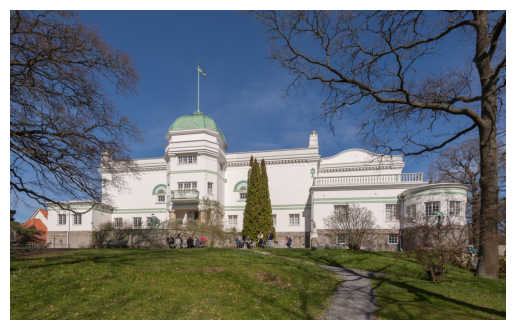

Ajoutez des balises pour Thielska%20galleriet%20April%202015.jpg (séparées par des virgules) :  bleu


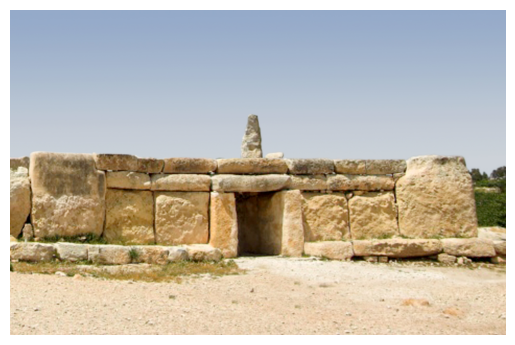

Ajoutez des balises pour Facade%20Hagar%20Qim.jpg (séparées par des virgules) :  jaune


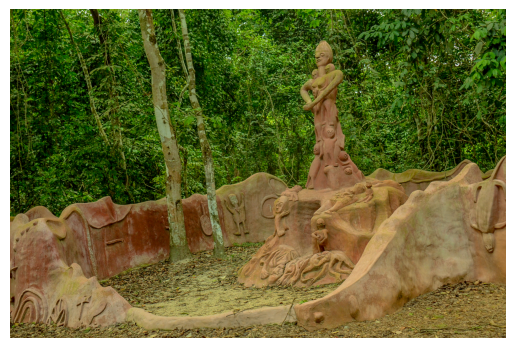

Ajoutez des balises pour Osun%20Osogbo%20forest%2C%20river%20and%20sacred%20groove%2013.jpg (séparées par des virgules) :  vert


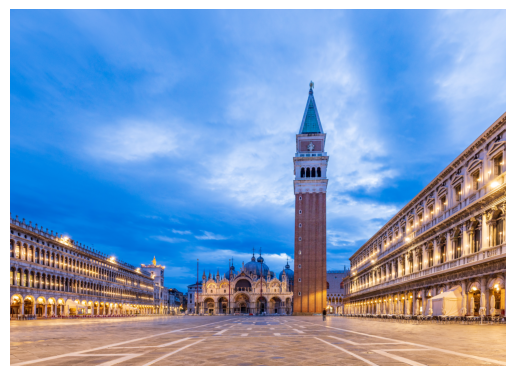

Ajoutez des balises pour Piazza%20San%20Marco%20%28Venice%29%20at%20night-msu-2021-6449-.jpg (séparées par des virgules) :  bleu


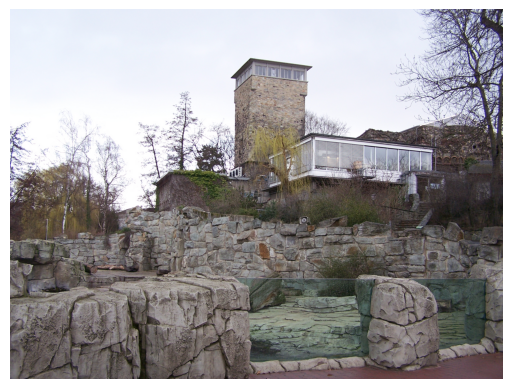

Ajoutez des balises pour Exotarium%2C%20Zoo%20Frankfurt.jpg (séparées par des virgules) :  


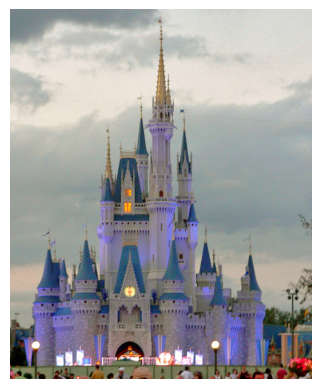

Ajoutez des balises pour Magic%20Kingdom%20castle.jpg (séparées par des virgules) :  


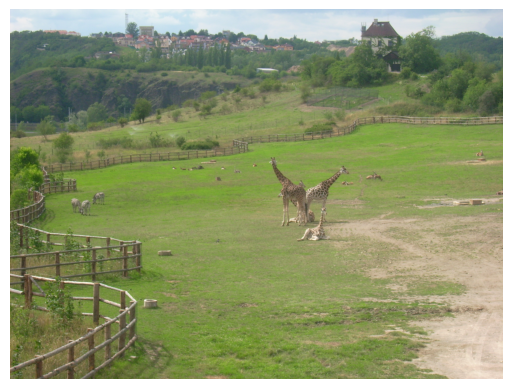

Ajoutez des balises pour Zoo%20Praha.JPG (séparées par des virgules) :  


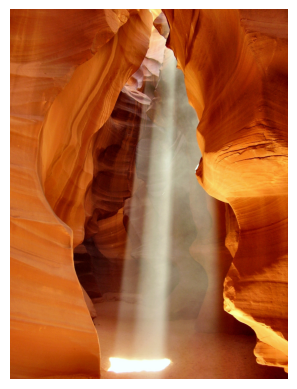

Ajoutez des balises pour USA%20Antelope-Canyon.jpg (séparées par des virgules) :  


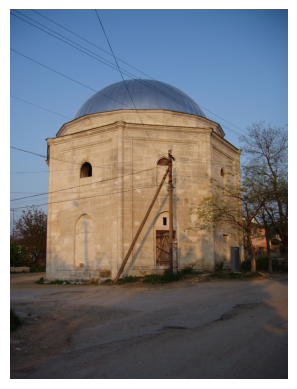

Ajoutez des balises pour EskiYurt.MehmedGiray.JPG (séparées par des virgules) :  


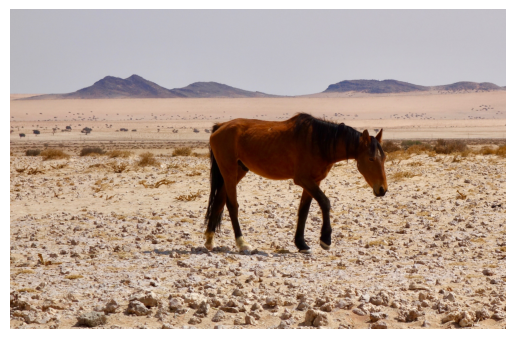

Ajoutez des balises pour Wild%20Horses%20%2837719691601%29.jpg (séparées par des virgules) :  



Profil utilisateur généré : {
    "favorite_colors": [
        [
            "really light blue",
            5
        ],
        [
            "cloudy blue",
            2
        ],
        [
            "windows blue",
            2
        ]
    ],
    "favorite_orientations": [
        [
            "paysage",
            7
        ]
    ],
    "favorite_sizes": [
        [
            "grande",
            9
        ]
    ],
    "favorite_tags": [
        [
            "",
            6
        ],
        [
            "bleu",
            2
        ],
        [
            "jaune",
            1
        ]
    ]
}
✅ Profil utilisateur enregistré dans 'user_profile.json'


In [2]:
import os
import json
import random
import matplotlib.pyplot as plt
from PIL import Image
from PIL.ExifTags import TAGS
from collections import Counter

### --- Chargement de la palette de couleurs XKCD --- ###
def load_xkcd_colors():
    return {
        "cloudy blue": "#acc2d9", "dark pastel green": "#56ae57",
        "dust": "#b2996e", "electric lime": "#a8ff04",
        "fresh green": "#69d84f", "light eggplant": "#894585",
        "nasty green": "#70b23f", "really light blue": "#d4ffff",
        "tea": "#65ab7c", "warm purple": "#952e8f",
        "yellowish tan": "#fcfc81", "cement": "#a5a391",
        "dark grass green": "#388004", "dusty teal": "#4c9085",
        "grey teal": "#5e9b8a", "macaroni and cheese": "#efb435",
        "pinkish tan": "#d99b82", "spruce": "#0a5f38",
        "strong blue": "#0c06f7", "toxic green": "#61de2a",
        "windows blue": "#3778bf", "blue blue": "#2242c7",
        "blue with a hint of purple": "#533cc6", "booger": "#9bb53c",
        "bright sea green": "#05ffa6", "dark green blue": "#1f6357",
        "deep turquoise": "#017374", "green teal": "#0cb577",
        "strong pink": "#ff0789", "bland": "#afa88b",
        "deep aqua": "#08787f", "lavender pink": "#dd85d7",
        "light moss green": "#a6c875", "light seafoam green": "#a7ffb5",
        "olive yellow": "#c2b709", "pig pink": "#e78ea5",
        "deep lilac": "#966ebd", "desert": "#ccad60",
        "dusty lavender": "#ac86a8", "purpley grey": "#947e94",
        "purply": "#983fb2", "candy pink": "#ff63e9",
        "light pastel green": "#b2fba5", "boring green": "#63b365"
    }

### --- Trouver la couleur nommée la plus proche --- ###
def closest_xkcd_color(requested_color):
    xkcd_colors = load_xkcd_colors()
    min_distance = float("inf")
    closest_name = "unknown"
    
    for name, hex_code in xkcd_colors.items():
        r_c, g_c, b_c = [int(hex_code[i:i+2], 16) for i in (1, 3, 5)]
        distance = sum((requested_color[i] - [r_c, g_c, b_c][i]) ** 2 for i in range(3))
        
        if distance < min_distance:
            min_distance = distance
            closest_name = name
            
    return closest_name

### --- Récupération de la couleur dominante --- ###
def get_dominant_color(image, num_colors=5):
    image = image.convert("RGB")
    pixels = list(image.getdata())
    most_common_colors = Counter(pixels).most_common(num_colors)
    dominant_color = most_common_colors[0][0] if most_common_colors else (0, 0, 0)
    
    return "#{:02x}{:02x}{:02x}".format(*dominant_color), closest_xkcd_color(dominant_color)

### --- Extraction des métadonnées EXIF --- ###
def get_exif_data(image):
    exif_data = {}
    try:
        exif_raw = image._getexif()
        if exif_raw:
            for tag, value in exif_raw.items():
                tag_name = TAGS.get(tag, tag)
                exif_data[tag_name] = value
        return exif_data.get("Make", "Inconnu"), exif_data.get("Model", "Inconnu"), exif_data.get("DateTimeOriginal", "Inconnue")
    except Exception:
        return "Inconnu", "Inconnu", "Inconnue"

### --- Affichage des images pour l'utilisateur --- ###
def show_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

### --- Analyse des images et collecte des préférences utilisateur --- ###
def analyze_images(folder_path, max_images=10):
    metadata_list = []
    if not os.path.exists(folder_path):
        print(f"[✘] Le dossier '{folder_path}' n'existe pas.")
        return None

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff", ".webp"))]
    selected_images = random.sample(image_files, min(len(image_files), max_images))

    for file_name in selected_images:
        file_path = os.path.join(folder_path, file_name)
        try:
            with Image.open(file_path) as img:
                dominant_color_hex, dominant_color_name = get_dominant_color(img)
                device_make, device_model, creation_date = get_exif_data(img)

                show_image(file_path)  # Affiche l'image pour aider l'utilisateur à choisir des balises
                
                user_tags = input(f"Ajoutez des balises pour {file_name} (séparées par des virgules) : ").split(", ")

                metadata = {
                    "file_name": file_name,
                    "path": file_path,
                    "width": img.width,
                    "height": img.height,
                    "format": img.format,
                    "orientation": "paysage" if img.width > img.height else "portrait" if img.height > img.width else "carré",
                    "dominant_color": dominant_color_name,
                    "device_make": device_make,
                    "device_model": device_model,
                    "creation_date": creation_date,
                    "user_tags": user_tags
                }
                metadata_list.append(metadata)
        except Exception as e:
            print(f"[✘] Erreur lors de la lecture de {file_name} : {e}")

    return metadata_list

### --- Génération du profil utilisateur --- ###
def create_user_profile(metadata_list):
    color_prefs = Counter([img["dominant_color"] for img in metadata_list])
    orientation_prefs = Counter([img["orientation"] for img in metadata_list])
    size_prefs = Counter([("petite" if img["width"] < 500 else "moyenne" if img["width"] < 1500 else "grande") for img in metadata_list])
    tag_prefs = Counter([tag for img in metadata_list for tag in img["user_tags"]])

    return {
        "favorite_colors": color_prefs.most_common(3),
        "favorite_orientations": orientation_prefs.most_common(1),
        "favorite_sizes": size_prefs.most_common(1),
        "favorite_tags": tag_prefs.most_common(3),
    }

### --- Exécution du script --- ###
folder_path = "images"
metadata_results = analyze_images(folder_path, max_images=10)

if metadata_results:
    user_profile = create_user_profile(metadata_results)
    print("\nProfil utilisateur généré :", json.dumps(user_profile, indent=4, ensure_ascii=False))

    with open("user_profile.json", "w", encoding="utf-8") as json_file:
        json.dump(user_profile, json_file, indent=4, ensure_ascii=False)
    print("✅ Profil utilisateur enregistré dans 'user_profile.json'")

 




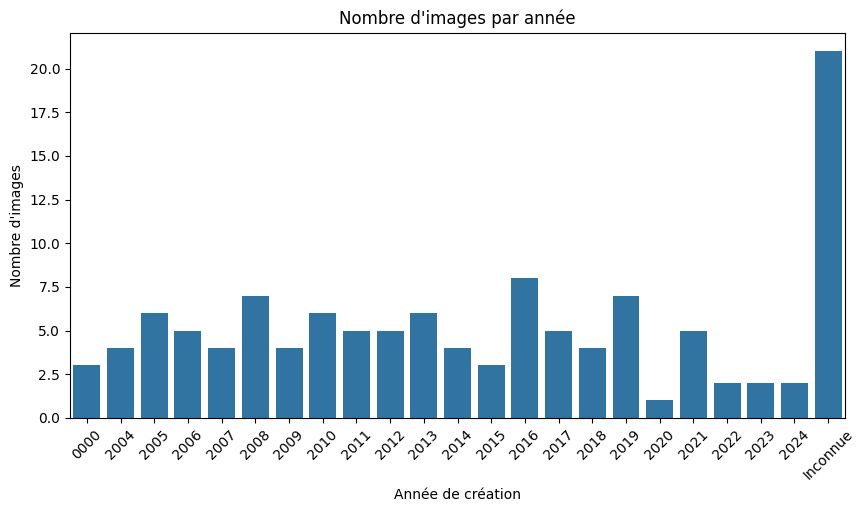

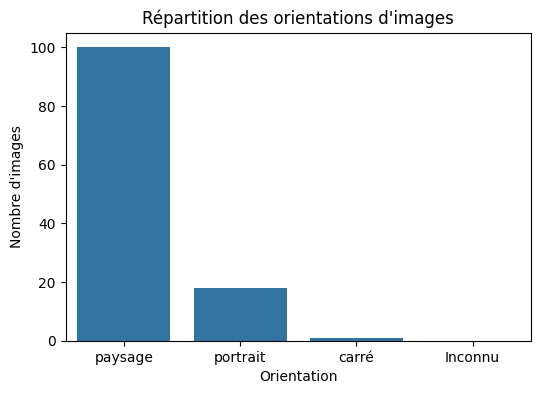

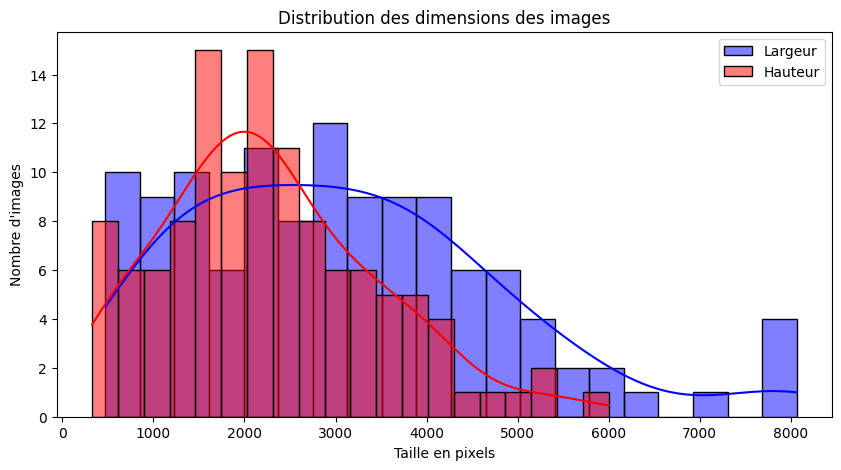

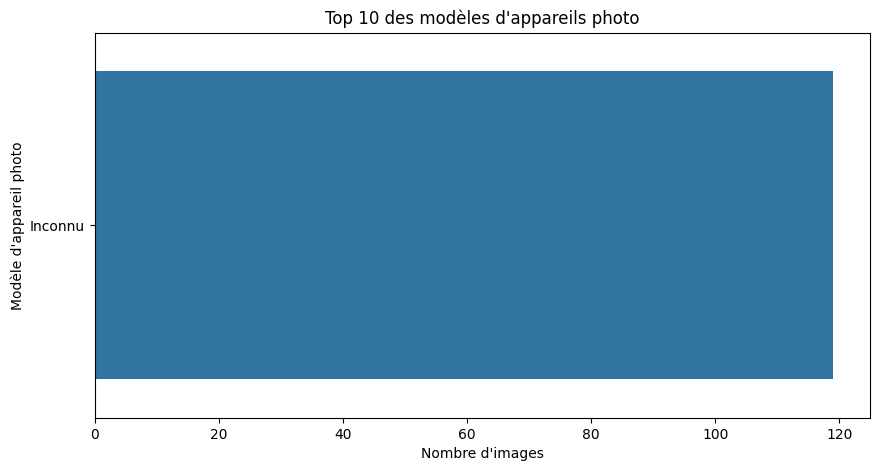

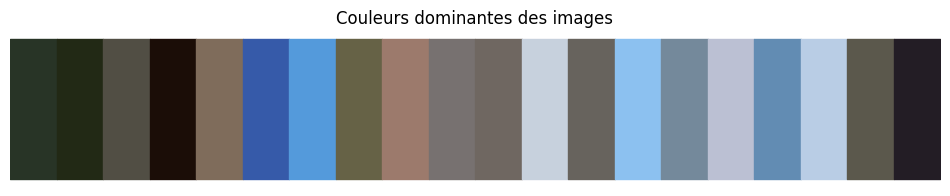

✅ Visualisation des données terminée !


In [2]:
import json
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from sklearn.cluster import KMeans

# Charger les métadonnées
metadata_file = "images_metadata.json"
if not os.path.exists(metadata_file):
    print("[✘] Fichier de métadonnées introuvable.")
    exit()

with open(metadata_file, "r", encoding="utf-8") as f:
    metadata_list = json.load(f)

# Extraction des données
creation_years = []
orientations = []
camera_models = []
widths = []
heights = []
colors = []

for data in metadata_list:
    if data.get("creation_date"):
        creation_years.append(data["creation_date"].split(":")[0])  # Extraire l'année
    orientations.append(data.get("orientation", "Inconnu"))
    camera_models.append(data.get("camera_model", "Inconnu"))
    widths.append(data.get("width", 0))
    heights.append(data.get("height", 0))
    
    # Extraction des couleurs dominantes avec plusieurs clusters
    img_path = data.get("path")
    if img_path and os.path.exists(img_path):
        try:
            img = Image.open(img_path)
            img = img.resize((100, 100))  # Augmenter la résolution d'analyse
            pixels = np.array(img).reshape(-1, 3)
            kmeans = KMeans(n_clusters=3, n_init=10)  # Utiliser plusieurs clusters
            kmeans.fit(pixels)
            dominant_color = kmeans.cluster_centers_[np.argmax(np.bincount(kmeans.labels_))]
            colors.append(tuple(dominant_color))
        except:
            pass

# Graphique : Nombre d'images par année
plt.figure(figsize=(10, 5))
sns.countplot(x=creation_years, order=sorted(set(creation_years)))
plt.xlabel("Année de création")
plt.ylabel("Nombre d'images")
plt.title("Nombre d'images par année")
plt.xticks(rotation=45)
plt.show()

# Graphique : Répartition des orientations
plt.figure(figsize=(6, 4))
sns.countplot(x=orientations, order=["paysage", "portrait", "carré", "Inconnu"])
plt.xlabel("Orientation")
plt.ylabel("Nombre d'images")
plt.title("Répartition des orientations d'images")
plt.show()

# Graphique : Distribution des tailles
plt.figure(figsize=(10, 5))
sns.histplot(widths, bins=20, kde=True, color='blue', label='Largeur')
sns.histplot(heights, bins=20, kde=True, color='red', label='Hauteur')
plt.xlabel("Taille en pixels")
plt.ylabel("Nombre d'images")
plt.title("Distribution des dimensions des images")
plt.legend()
plt.show()

# Graphique : Modèles d'appareils photo les plus utilisés
plt.figure(figsize=(10, 5))
camera_counts = Counter(camera_models)
camera_common = camera_counts.most_common(10)
sns.barplot(y=[x[0] for x in camera_common], x=[x[1] for x in camera_common])
plt.xlabel("Nombre d'images")
plt.ylabel("Modèle d'appareil photo")
plt.title("Top 10 des modèles d'appareils photo")
plt.show()

# Graphique : Couleurs dominantes
if colors:
    plt.figure(figsize=(12, 2))
    for i, color in enumerate(colors[:20]):  # Afficher seulement 20 couleurs
        plt.fill_between([i, i + 1], 0, 1, color=np.array(color) / 255)
    plt.xlim(0, len(colors[:20]))
    plt.axis("off")
    plt.title("Couleurs dominantes des images")
    plt.show()

print("✅ Visualisation des données terminée !")